In [1]:
import json
import pandas as pd
import numpy as np
import prettytable as pt
import os
import warnings
warnings.filterwarnings("ignore")


###################################################################################################
                                                                                                  #
from rhoova.Client import *                                                                       #   
#Register and get api key from https://app.rhoova.com/ for ClientConfig("api key", "api secret")  #
config = ClientConfig("", "")                #                                                     #
api = Api(config)                                                                                 # 
                                                                                                  #
###################################################################################################

directory = os.path.normpath(os.getcwd() + os.sep + os.pardir + os.sep + os.pardir)
datadirectory=directory+"/data/yielddata/yielddata.csv"


yielddata = pd.read_csv(datadirectory)
yielddata = yielddata.replace(np.nan, '', regex=True) 

yieldData= yielddata.to_dict('r')

In [2]:
# Fix parameters for building yield curve instruments
leg1DiscountCurveInstrumentsConfig={
            "FUTURES": {
                "businessDayConvention": "ModifiedFollowing",
                "dayCounter": "Actual360",
                "market": "IMM",
            },
            "IRS": {
                "businessDayConvention": "ModifiedFollowing",
                "dayCounter": "Thirty360",
                "frequency": "Semiannual"
            }
        } 

In [3]:
# Fix parameters for building yield curve

leg1DiscountCurveConfig={
        "settlementDays": 2,
        "intpMethod": "Linear",
        "currency": "USD",
        "calendar": "UnitedStates",
        "dayCounter": "Thirty360",
        "period": "3M",
        "instruments":leg1DiscountCurveInstrumentsConfig,}

In [4]:
# Fix parameters for building yield curve instruments
leg2DiscountCurveInstrumentsConfig={
             "OIS": {
               "frequency": "Annual",
               "businessDayConvention": "ModifiedFollowing"
             },
             "DEPO": {
               "businessDayConvention": "ModifiedFollowing",
               "dayCounter": "Actual360"
             }
           }

In [5]:
# Fix parameters for building yield curve

leg2DiscountCurveConfig={
        "settlementDays": 2,
        "intpMethod": "Linear",
        "currency": "EUR",
        "calendar": "TARGET",
        "dayCounter": "Actual365Fixed",
        "period": "1D",
        "instruments":leg2DiscountCurveInstrumentsConfig,}

In [6]:
leg1={
      "type": "Fixed",
      "payOrReceive": "Receive",
      "frequency": "Semiannual",
      "coupon": 0.00971619,
      "notional": 10000000,
      "currency": "USD",
      "initialNominal": 10000000,
      "dayCounter": "Thirty360",
      "calendar": "UnitedStates",
      "maturityDateConvention": "ModifiedFollowing",
      "businessDayConvention": "ModifiedFollowing",
      "dateGeneration": "Backward",
      "endOfMonth": True,
      "spread": 0.0,
      "resetTable": False,
      "runningCapitalExchange": False,
      "fixingDate": ["2021-03-10"],
      "fixingRate": [0.0018413],
   #  "index":"",  // Optional
         }

In [7]:
leg2={
           "type": "Floating",
           "payOrReceive": "Pay",
           "frequency": "Quarterly",
           #"index":"EURLibor3M",
           "spread": 0,
           "notional": 8384478.65,
           "currency": "EUR",
           "initialNominal": 8384478.65,
           "dayCounter": "Actual360",
           "calendar": "TARGET",
           "maturityDateConvention": "ModifiedFollowing",
           "businessDayConvention": "ModifiedFollowing",
           "dateGeneration": "Backward",
           "endOfMonth": True,
           "coupon": 0.0,
           "resetTable": False,
           "runningCapitalExchange": False,
           "fixingDate": ["2021-03-10"],
           "fixingRate": [-0.00477]
         }

In [8]:
data = {
        "valuationDate": "2021-03-10",
        "settlementDate": "2021-03-12",
        "maturityDate": "2026-03-12",
        "startDate": "2021-03-12",
        "spotPrice": 1.19268,
        "leg1": leg1,
        "leg2": leg2,
        "leg1DiscountCurve": leg1DiscountCurveConfig,
        "leg2DiscountCurve": leg2DiscountCurveConfig,
        "leg2ForecastCurve": leg2DiscountCurveConfig,
         "yieldData": yieldData
       }
try:
    data = api.createTask(CalculationType.CROSS_CURRENCY, data, True)
    result=json.loads(data["result"])


except RhoovaError as e:
    e.printPretty()


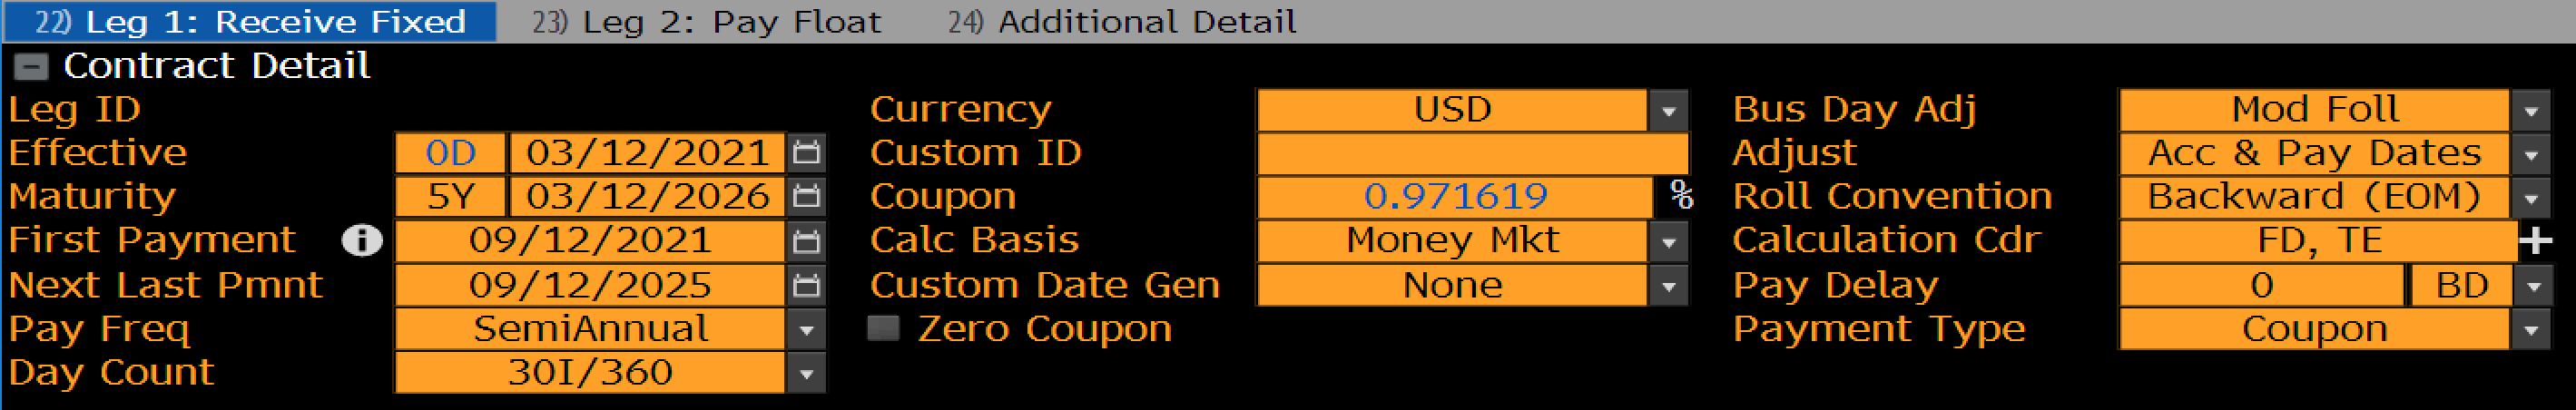

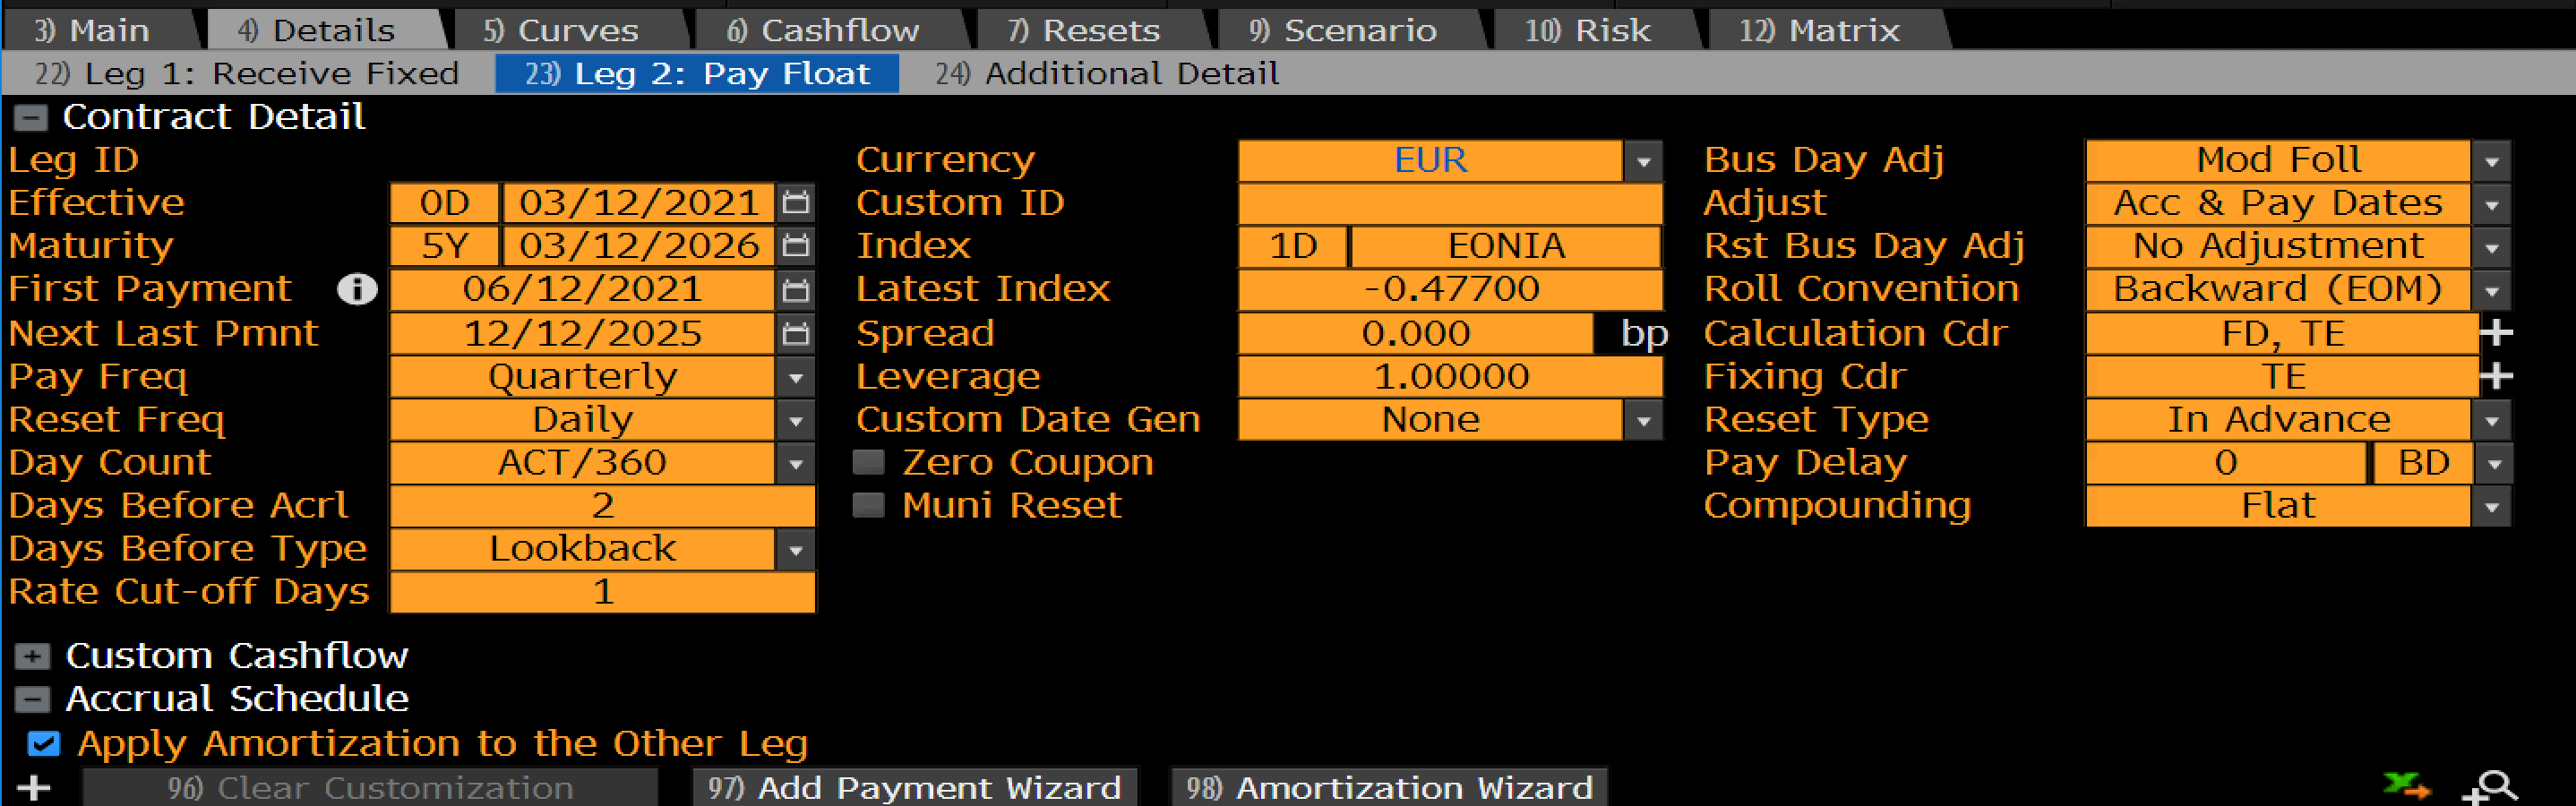

In [9]:
cashflow=pd.DataFrame(result.get('data'))

In [10]:


npvTable = pt.PrettyTable(['Parameters', 'Value'])
npvTable.add_row(['Fixed Leg PV', result.get('leg1Pv')])
npvTable.add_row(['Float Leg PV', result.get('leg2Pv')])
npvTable.add_row(['Leg1 BPS', result.get('leg1Bps')])
npvTable.add_row(['Leg2 BPS', result.get('leg2Bps')])
npvTable.add_row(['Base Currency', result.get('baseCurrency')])
npvTable.add_row(['Base Currency PV', result.get('baseCurrencyResult')])
npvTable.add_row(['Quoted Currency', result.get('quotedCurrency')])
npvTable.add_row(['Quoted Currency PV', result.get('quotedCurrencyResult')])
npvTable.add_row(['Spot Rate', result.get('spotRate')])
npvTable.align = 'r'
npvTable.float_format = '.4'
print(npvTable)



+--------------------+---------------+
|         Parameters |         Value |
+--------------------+---------------+
|       Fixed Leg PV | 10051036.3640 |
|       Float Leg PV | -8384632.0936 |
|           Leg1 BPS |     4924.0750 |
|           Leg2 BPS |    -4302.6350 |
|      Base Currency |           EUR |
|   Base Currency PV |    42637.8864 |
|    Quoted Currency |           USD |
| Quoted Currency PV |    50853.3586 |
|          Spot Rate |        1.1927 |
+--------------------+---------------+


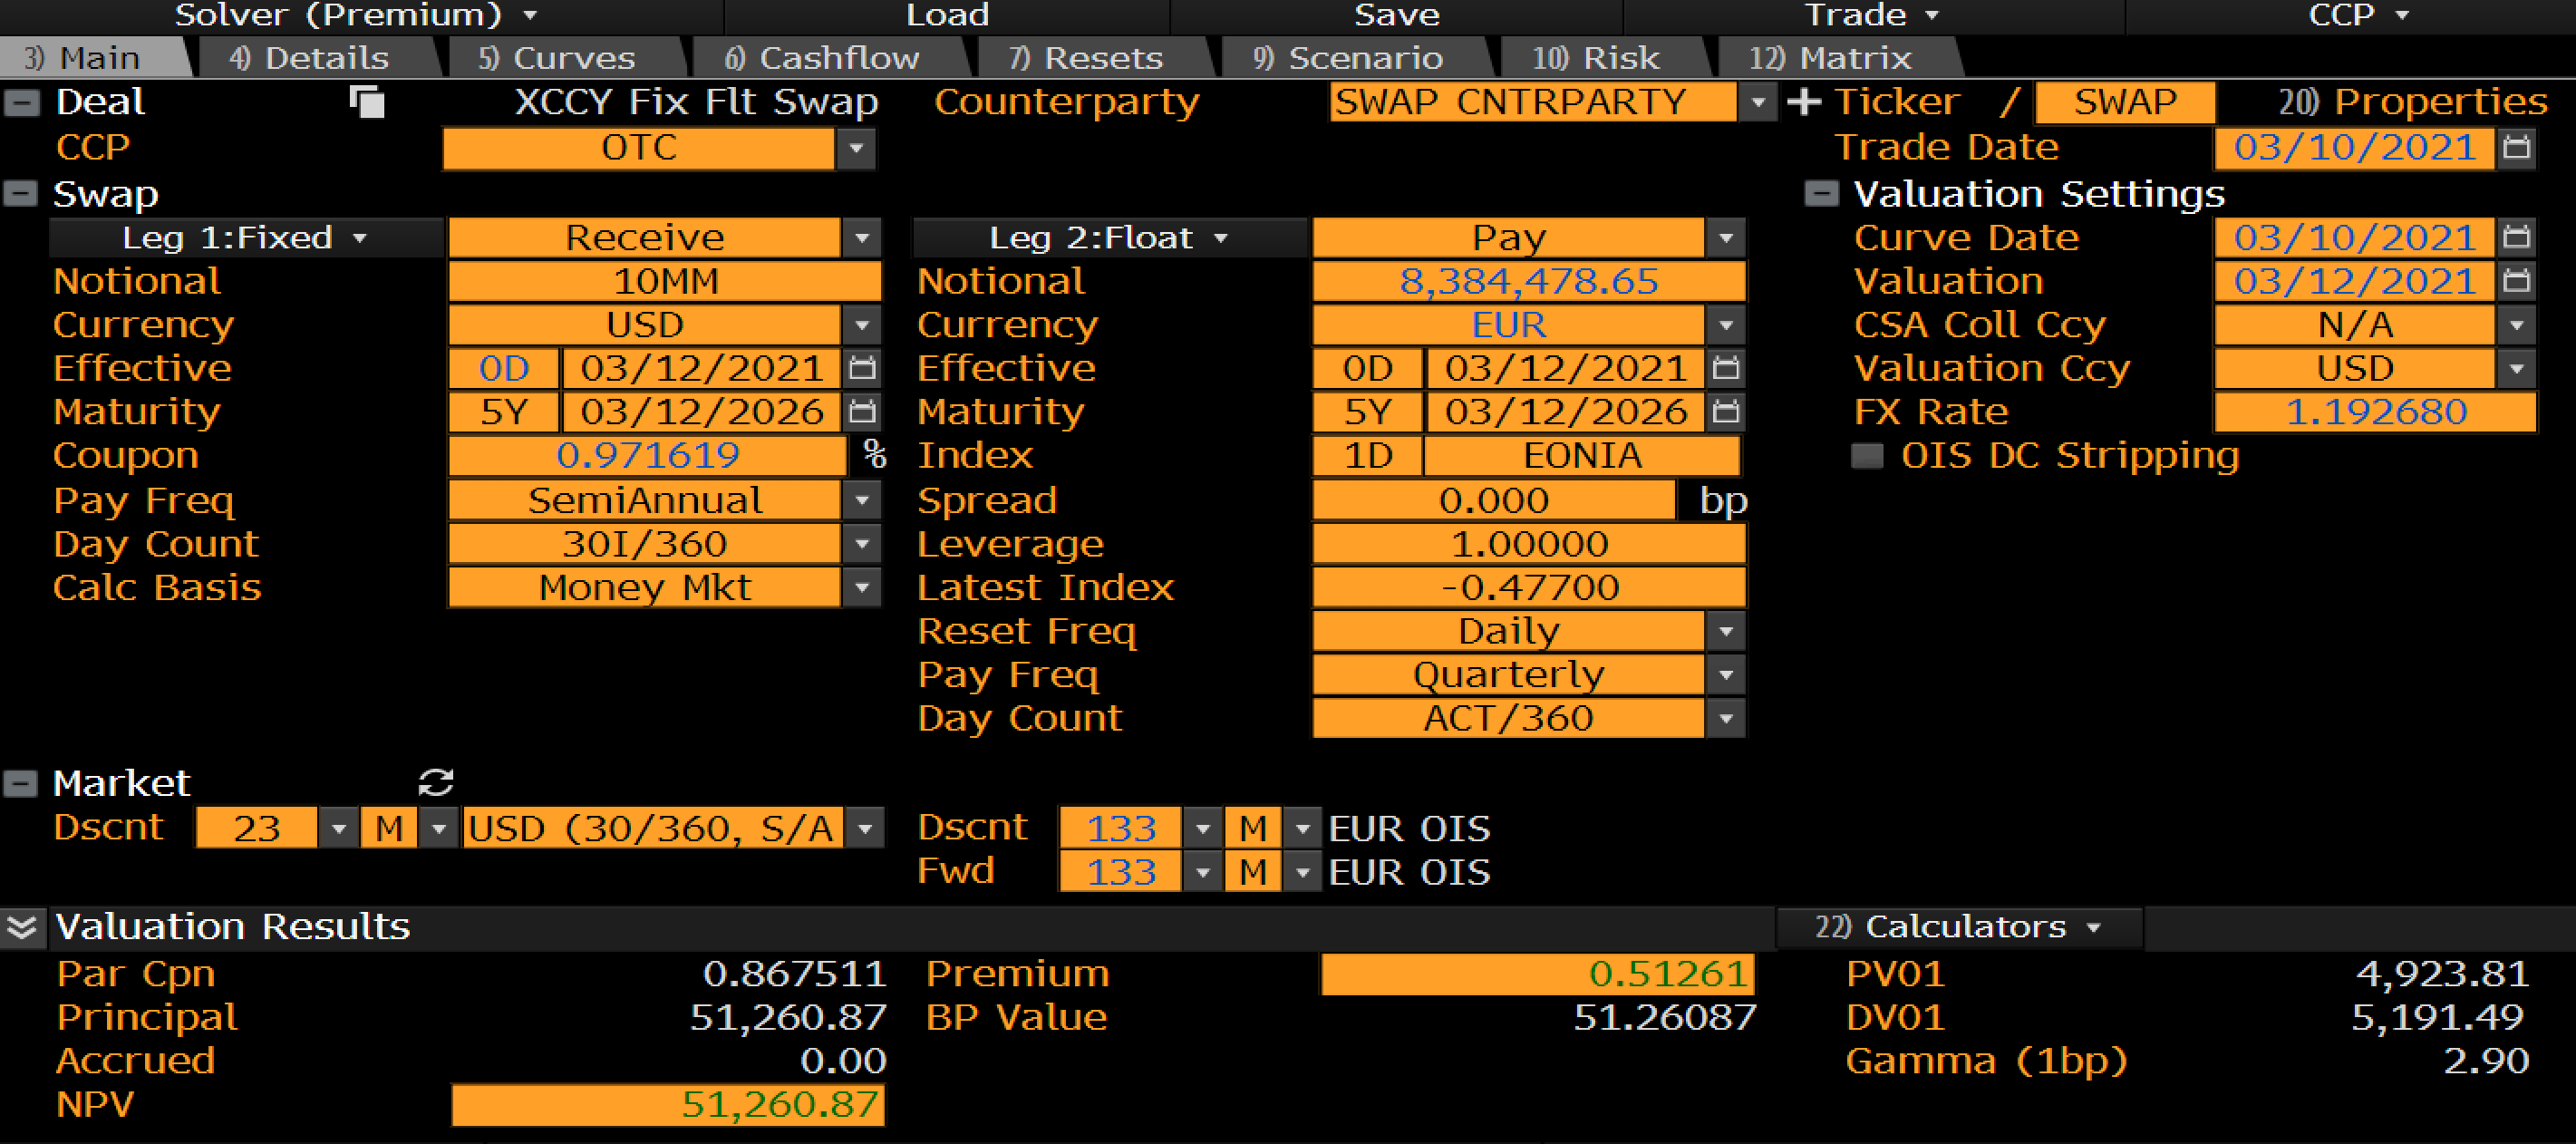

In [11]:
cashflow[cashflow['leg']=='Fixed']

,fixingDate,accrualStart,accrualEnd,notional,currency,leg,payOrReceive,instrument,rate,zeroRate,spread,termToMatByDay,termToMatByYear,cashflow,discountFactor,cashflowPv
0,2021-03-10,2021-03-12,2021-03-10,-10000000,USD,Fixed,Receive,Cross Currency Swap,0.000000,0.000000,0,1800,5.000000,0.000000e+00,0.000000,-1.000000e+07
1,2021-03-10,2021-03-12,2021-09-13,10000000,USD,Fixed,Receive,Cross Currency Swap,0.009716,0.001818,0,181,0.502778,4.885084e+04,0.999086,4.880621e+04
2,2021-09-09,2021-09-13,2022-03-14,10000000,USD,Fixed,Receive,Cross Currency Swap,0.009716,0.001788,0,362,1.005556,4.885084e+04,0.998204,4.876310e+04
3,2022-03-10,2022-03-14,2022-09-12,10000000,USD,Fixed,Receive,Cross Currency Swap,0.009716,0.001956,0,540,1.500000,4.804116e+04,0.997070,4.790042e+04
4,2022-09-08,2022-09-12,2023-03-13,10000000,USD,Fixed,Receive,Cross Currency Swap,0.009716,0.002438,0,721,2.002778,4.885084e+04,0.995129,4.861291e+04
5,2023-03-09,2023-03-13,2023-09-12,10000000,USD,Fixed,Receive,Cross Currency Swap,0.009716,0.003292,0,900,2.500000,4.831106e+04,0.991803,4.791505e+04
6,2023-09-08,2023-09-12,2024-03-12,10000000,USD,Fixed,Receive,Cross Currency Swap,0.009716,0.004152,0,1080,3.000000,4.858095e+04,0.987623,4.797965e+04
7,2024-03-08,2024-03-12,2024-09-12,10000000,USD,Fixed,Receive,Cross Currency Swap,0.009716,0.005340,0,1260,3.500000,4.858095e+04,0.981482,4.768132e+04
8,2024-09-10,2024-09-12,2025-03-12,10000000,USD,Fixed,Receive,Cross Currency Swap,0.009716,0.006529,0,1440,4.000000,4.858095e+04,0.974220,4.732855e+04
9,2025-03-10,2025-03-12,2025-09-12,10000000,USD,Fixed,Receive,Cross Currency Swap,0.009716,0.007633,0,1620,4.500000,4.858095e+04,0.966236,4.694066e+04


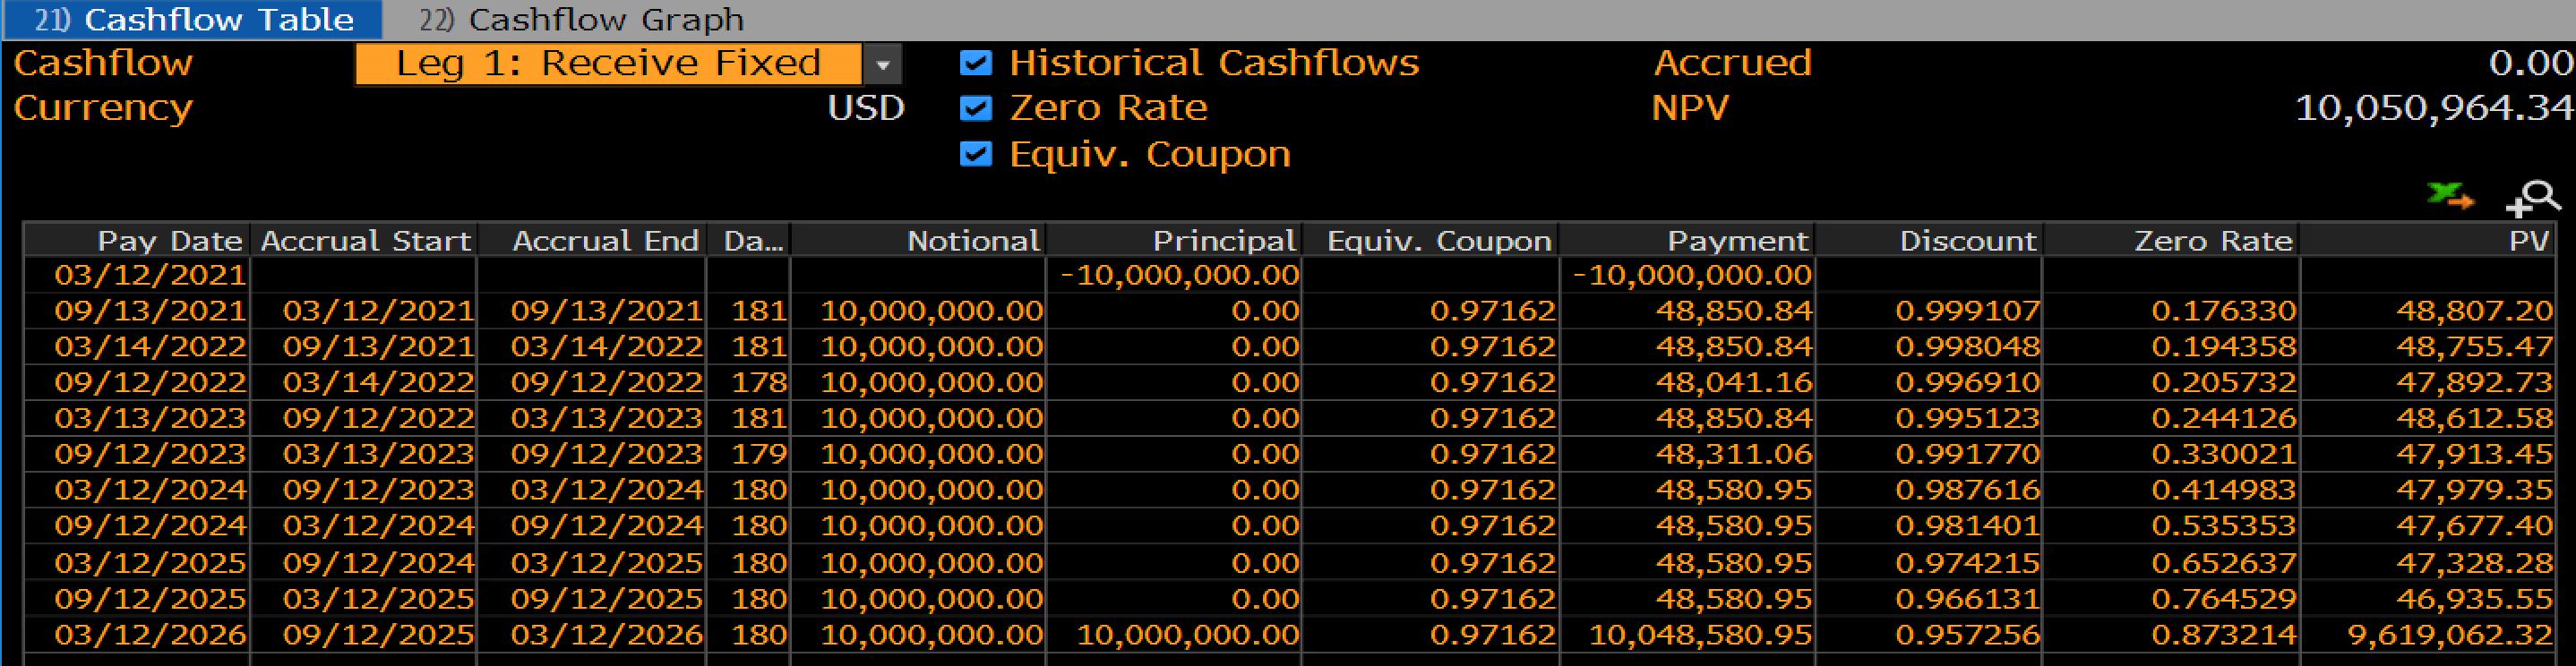

In [12]:
cashflow[cashflow['leg']=='Floating']

,fixingDate,accrualStart,accrualEnd,notional,currency,leg,payOrReceive,instrument,rate,zeroRate,spread,termToMatByDay,termToMatByYear,cashflow,discountFactor,cashflowPv
12,2021-03-10,2021-03-12,2021-03-10,-8384478,EUR,Floating,Pay,Cross Currency Swap,0.000000,0.000000,0,1826,5.072222,-8.384478e+06,0.000000,0.000000e+00
13,2021-03-10,2021-03-12,2021-06-14,8384478,EUR,Floating,Pay,Cross Currency Swap,-0.004770,-0.004843,0,94,0.261111,-1.044287e+04,1.001265,-1.045608e+04
14,2021-06-10,2021-06-14,2021-09-13,8384478,EUR,Floating,Pay,Cross Currency Swap,-0.004917,-0.004881,0,185,0.513889,-1.042192e+04,1.002512,-1.044809e+04
15,2021-09-09,2021-09-13,2021-12-13,8384478,EUR,Floating,Pay,Cross Currency Swap,-0.004902,-0.004889,0,276,0.766667,-1.039029e+04,1.003755,-1.042931e+04
16,2021-12-09,2021-12-13,2022-03-14,8384478,EUR,Floating,Pay,Cross Currency Swap,-0.004939,-0.004902,0,367,1.019444,-1.046736e+04,1.005010,-1.051980e+04
17,2022-03-10,2022-03-14,2022-06-13,8384478,EUR,Floating,Pay,Cross Currency Swap,-0.004919,-0.004906,0,458,1.272222,-1.042552e+04,1.006261,-1.049079e+04
18,2022-06-09,2022-06-13,2022-09-12,8384478,EUR,Floating,Pay,Cross Currency Swap,-0.004927,-0.004910,0,549,1.525000,-1.044225e+04,1.007516,-1.052074e+04
19,2022-09-08,2022-09-12,2022-12-12,8384478,EUR,Floating,Pay,Cross Currency Swap,-0.004914,-0.004911,0,640,1.777778,-1.041553e+04,1.008769,-1.050687e+04
20,2022-12-08,2022-12-12,2023-03-13,8384478,EUR,Floating,Pay,Cross Currency Swap,-0.004916,-0.004912,0,731,2.030556,-1.041991e+04,1.010024,-1.052436e+04
21,2023-03-09,2023-03-13,2023-06-12,8384478,EUR,Floating,Pay,Cross Currency Swap,-0.004252,-0.004839,0,822,2.283333,-9.012521e+03,1.011111,-9.112661e+03


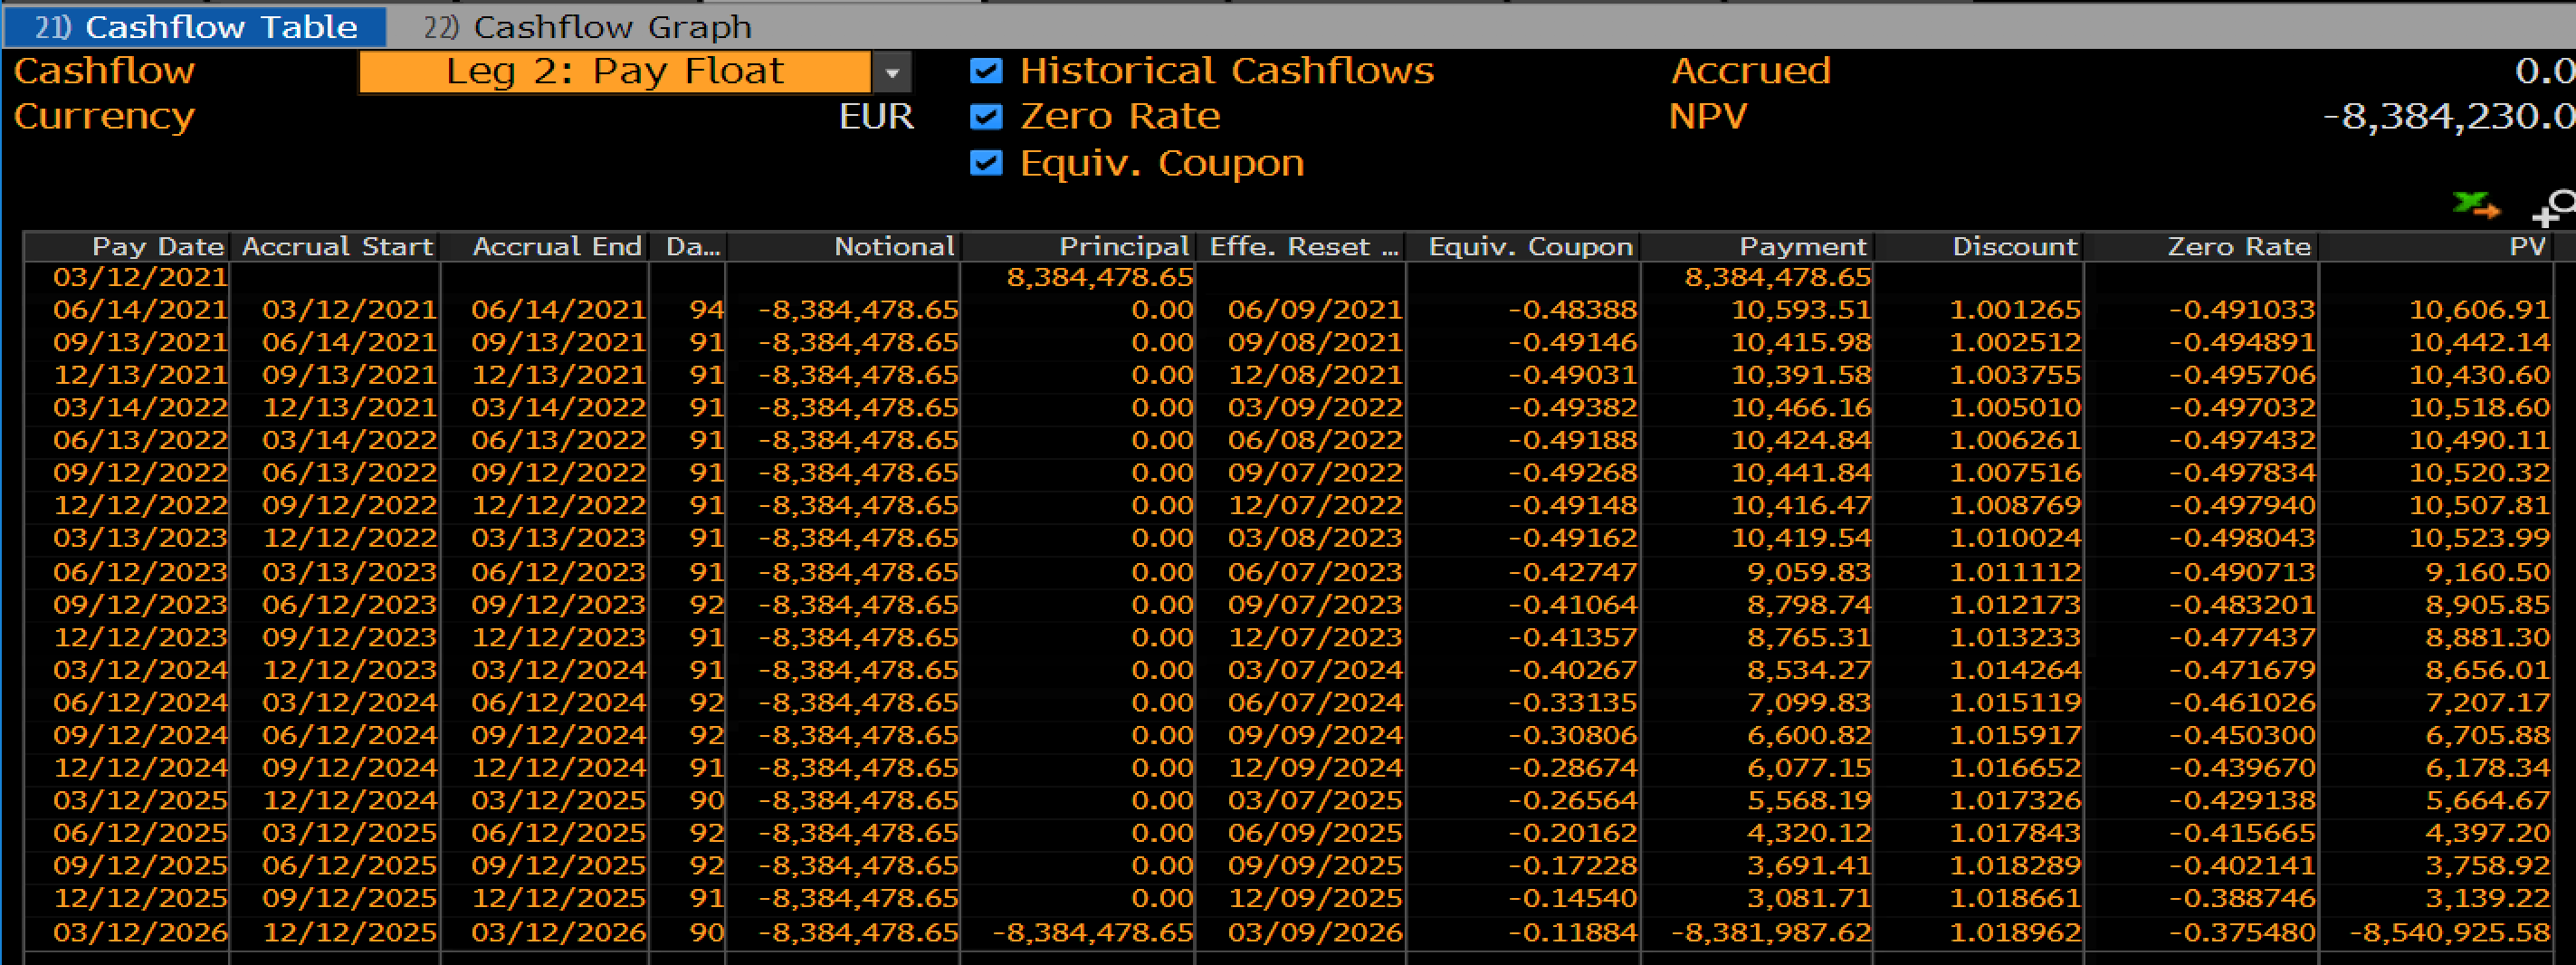

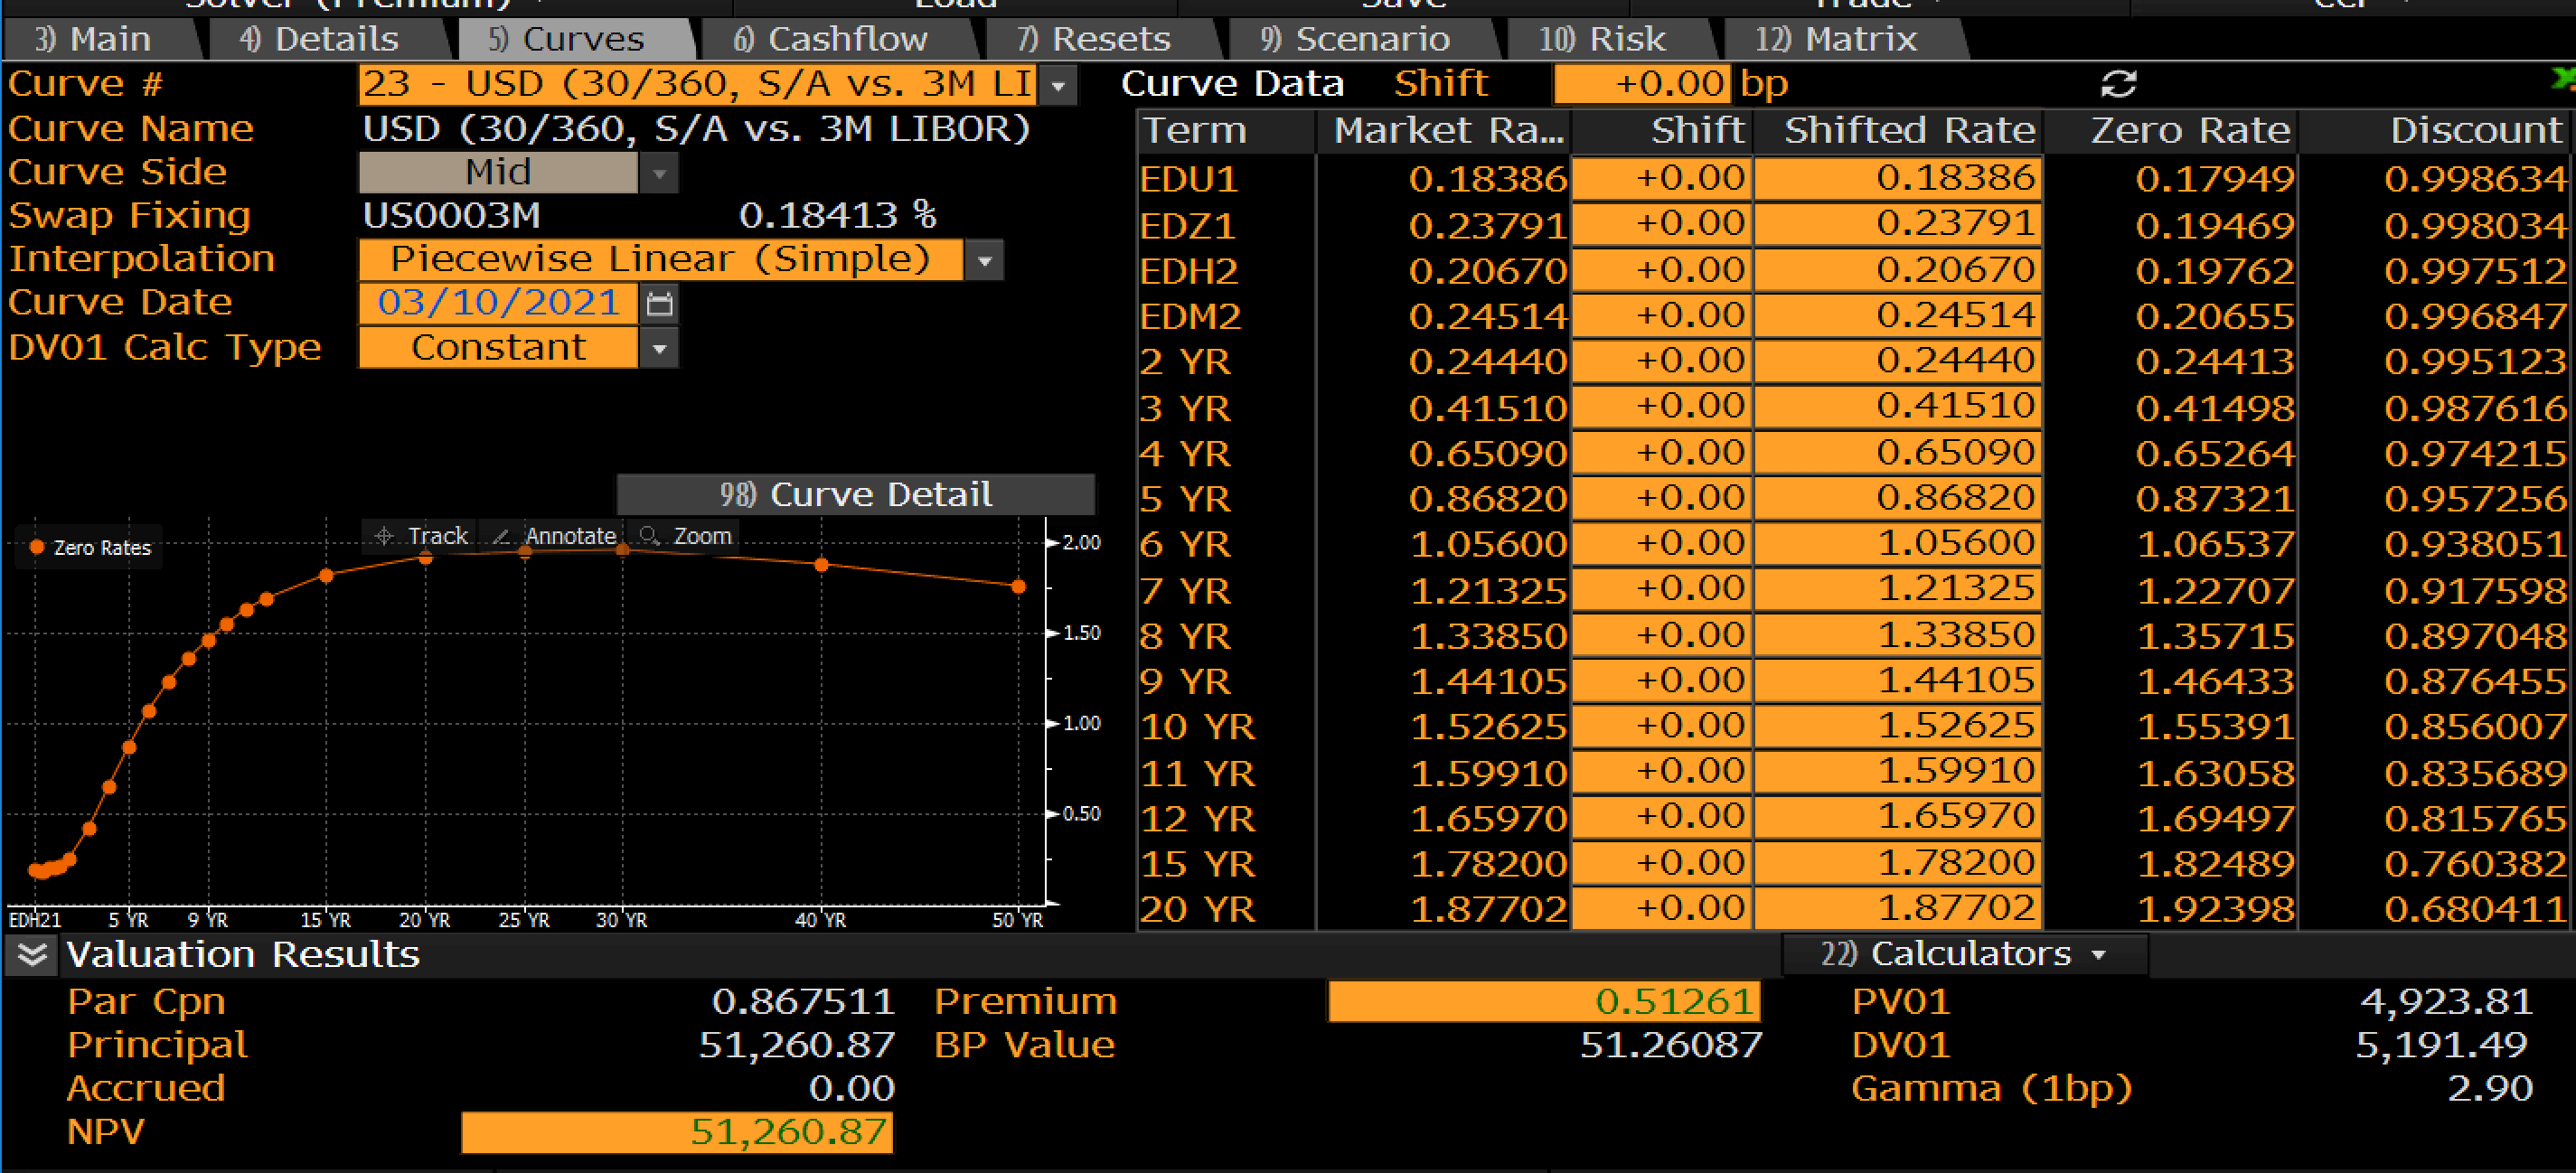

<div><img src="reset.png"  style="width: 400px;height:600px" align="left"/></div> 